# Street sign with Pre-Trained WideResNet

With additional self supervised learning, predicting rotations

In [40]:
import random

from torch.optim import SGD
import seaborn as sb 
from gtsrb import GTSRB
from detectors import EnsembleDetector, LogicOOD
import torch
from pytorch_ood.utils import fix_random_seed

fix_random_seed(123)

def seed_worker(worker_id):
    fix_random_seed(worker_id)

g = torch.Generator()
g.manual_seed(0)
sb.set()

device="cuda:0"
root = "../data/"


In [41]:
from torchvision.transforms import ToTensor, Resize, Compose
import torch 
from torch.utils.data import DataLoader

trans = Compose([ToTensor(), Resize((32, 32), antialias=True)])

train_data = GTSRB(root=root, train=True, transforms=trans)
test_data = GTSRB(root=root, train=False, transforms=trans)

In [42]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=12, worker_init_fn=seed_worker)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=12, worker_init_fn=seed_worker)

In [43]:
from torch import nn
from pytorch_ood.model import WideResNet

# def override 
def Model(num_classes=None, *args, **kwargs):
    model = WideResNet(*args, num_classes=1000, **kwargs, pretrained="imagenet32")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [44]:

def train_model(att_index, num_classes):
    """
    train a model for the given attribute index 
    """
    trans = Compose([ToTensor(), Resize((32, 32), antialias=True)])
    train_data = GTSRB(root=root, train=True, transforms=trans)
    test_data = GTSRB(root=root, train=False, transforms=trans)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)
    
    model = Model(num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        bar = tqdm(train_loader)
        for inputs, y in bar:
            labels = y[:, att_index]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in test_loader:
                labels = y[:, att_index]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the test images: {correct / total:.2%}')

    return model 

# Rotation Network

In [45]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torchvision.transforms.functional import rotate

def rotate_aug(x, y):
    angle = int(random.choice([0, 1, 2, 3]))
    img = rotate(x, angle=angle * 90)
    return img, angle

def train_rotate_model():
    trans = Compose([ToTensor(), Resize((32, 32), antialias=True)])

    # tiny = TinyImages300k(root=root, download=True, transform=trans, target_transform=ToUnknown())
    # data_train_out, data_test_out, _ = random_split(tiny, [50000, 10000, 240000], generator=torch.Generator().manual_seed(123))

    train_data_noatt = GTSRB(root=root, train=True, transform=rotate_aug, transforms=trans)
    test_data_noatt = GTSRB(root=root, train=False, transform=rotate_aug, transforms=trans)

    new_loader = DataLoader(train_data_noatt, batch_size=32, shuffle=True, num_workers=10, worker_init_fn=seed_worker)
    new_test_loader = DataLoader(test_data_noatt, batch_size=32, shuffle=False, num_workers=10, worker_init_fn=seed_worker)

    model = Model(num_classes=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = None
        model.train()
        
        bar = tqdm(new_loader)
        for n, (inputs, y) in enumerate(bar):
            inputs, y = inputs.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item() if running_loss is not None else loss.item()
            bar.set_postfix({"loss": running_loss})

            # if n == 0:
            #     fix, axs = plt.subplots(1,4, figsize=(16, 9))
            #     for ax, img, lab, y_hat in zip(axs, inputs, y, outputs.argmax(dim=1)):
            #         ax.imshow(to_pil_image(img))
            #         ax.set_title(f"{lab.item()} - {y_hat.item()}")
            #         ax.grid(False)
            #         # Hide axes ticks
            #         ax.set_xticks([])
            #         ax.set_yticks([])
            #     plt.show()

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for n, (inputs, y) in enumerate(new_test_loader):
                inputs, y = inputs.to(device), y.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

                # if n == 0:
                #     fix, axs = plt.subplots(1,4, figsize=(16, 9))
                #     for ax, img, lab, y_hat in zip(axs, inputs, y, predicted):
                #         ax.imshow(to_pil_image(img))
                #         ax.set_title(f"{lab.item()} - {y_hat.item()}")
                #         ax.grid(False)
                #         # Hide axes ticks
                #         ax.set_xticks([])
                #         ax.set_yticks([])
                #     plt.show()

        print(f'Accuracy of the rotation network on the test images: {correct / total:.2%}')
        accs.append(correct / total)

    return model

# OOD Evaluation 

In [46]:
from pytorch_ood.dataset.img import (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import ToRGB, OODMetrics
from detectors import LogicOOD
from pytorch_ood.utils import ToUnknown

def evaluate(label_net, shape_net, color_net, rotation_net):
    _ = label_net.eval()
    _ = shape_net.eval()
    _ = color_net.eval()
    _ = rotation_net.eval()
    
    results = []

    trans = Compose([Resize(size=(32, 32), antialias=True), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
    # dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
    
    
    detectors = {
        "LogicOOD-R": LogicOOD(
             label_net,
            shape_net,
            color_net,
            GTSRB(root=root).class_to_shape,
            GTSRB(root=root).class_to_color,
            rotation_net=rotation_net
        ),
        "LogicOOD": LogicOOD(
            label_net,
            shape_net,
            color_net,
            GTSRB(root=root).class_to_shape,
            GTSRB(root=root).class_to_color,
        ),
         "Logic": LogicOOD(
             label_net,
            shape_net,
            color_net,
            GTSRB(root=root).class_to_shape,
            GTSRB(root=root).class_to_color,
            rotation_net=rotation_net
        ).consistent,
        "Ensemble": EnsembleDetector(label_net, shape_net, color_net),
        "MSP": MaxSoftmax(label_net),
        "Energy": EnergyBased(label_net),
    }
    
    datasets = {d.__name__: d for d in (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)}
    
    for detector_name, detector in detectors.items():
        for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
            scores = []
            ys = []
            
            with torch.no_grad():
                for x, y in loader:
                    scores.append(detector(x.to(device)))
                    ys.append(y.to(device))
                    
                scores = torch.cat(scores, dim=0).cpu()
                ys = torch.cat(ys, dim=0).cpu()
            
            metrics = OODMetrics()
            metrics.update(scores, ys)
            r = metrics.compute()
            r.update({
                "Method": detector_name,
                "Dataset": data_name
            })
            print(r)
            results.append(r)
    
    return results 

In [47]:
def evaluate_acc(net, att_idx=0, oe=False):
    _ = net.eval()
    
    if oe:
        target_trans = lambda y: torch.tensor(1)
    else:
         target_trans = lambda y: y[att_idx]

    trans = Compose([Resize(size=(32, 32), antialias=True), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=target_trans)
    loader = DataLoader(data_in, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            predicted = outputs.max(dim=1).indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total  

def evaluate_accs(label_net, shape_net, color_net, shield_net):
    r = {}
    names = ("Label", "Color", "Shape",)
    
    for n, net in enumerate((label_net, color_net, shape_net)): 
        acc = evaluate_acc(net, n)
        r[names[n]] = acc
    
    acc = evaluate_acc(shield_net, oe=True)
    r["Sign"] = acc
    
    return [r] 

In [48]:
results = []
results_acc = []

for trial in range(1):
    rotation_net = train_rotate_model()
    shape_net = train_model(att_index=2, num_classes=5)
    color_net = train_model(att_index=1, num_classes=4)
    label_net = train_model(att_index=0, num_classes=43)
    
    res = evaluate(label_net, shape_net, color_net, rotation_net)
    res_acc = evaluate_accs(label_net, shape_net, color_net, rotation_net)
    
    for r in res:
        r.update({"Seed": trial})
        
    for r in res_acc:
        r.update({"Seed": trial})
    
    results += res
    results_acc += res_acc

  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 97.29%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.21%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.36%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.26%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.73%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.46%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.83%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.69%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.80%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.76%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 99.01%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.78%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.74%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.70%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.87%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 99.10%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the rotation network on the test images: 98.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.85%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.87%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.87%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.49%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.63%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.83%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.87%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.73%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.04%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.02%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.84%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.18%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.03%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.04%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.26%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.26%
{'AUROC': 0.9941996335983276, 'AUPR-IN': 0.992180585861206, 'AUPR-OUT': 0.9972259402275085, 'FPR95TPR': 0.010292952880263329, 'Method': 'LogicOOD-R', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9938709735870361, 'AUPR-IN': 0.9913190603256226, 'AUPR-OUT': 0.9970018267631531, 'FPR95TPR': 0.010530482977628708, 'Method': 'LogicOOD-R', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9933876395225525, 'AUPR-IN': 0.9834429025650024, 'AUPR-OUT': 0.997776985168457, 'FPR95TPR': 0.01195566076785326, 'Method': 'LogicOOD-R', 'Dataset': 'Textures'}
{'AUROC': 0.9937673211097717, 'AUPR-IN': 0.9913177490234375, 'AUPR-OUT': 0.9969080090522766, 'FPR95TPR': 0.010768013074994087, 'Method': 'LogicOOD-R', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9936424493789673, 'AUPR-IN': 0.9909634590148926, 'AUPR-OUT': 0.9968287944793701, 'FPR95TPR': 0.010847189463675022, 'Method': 'LogicOOD-R', 'Dataset': 'TinyImageNetResize'}
{'AUROC': 0.9985780119895935, 'AUPR-IN': 0.9979462623596191, '

In [58]:
import pandas as pd 
result_df = pd.DataFrame(results)

s = (result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f")
print(s)

# with open("/home/ki/result.txt", "w") as f:
#
#     f.write(s)

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean &  sem &    mean &  sem &     mean &  sem &     mean &  sem \\
Method     &       &      &         &      &          &      &          &      \\
\midrule
Energy     & 97.94 & 0.29 &   97.83 & 0.41 &    97.80 & 0.28 &     5.15 & 0.97 \\
Ensemble   & 99.75 & 0.02 &   99.57 & 0.08 &    99.85 & 0.01 &     1.14 & 0.07 \\
Logic      & 92.74 & 0.68 &   95.16 & 0.64 &    95.41 & 0.45 &   100.00 & 0.00 \\
LogicOOD   & 99.86 & 0.02 &   99.76 & 0.06 &    99.92 & 0.01 &     0.51 & 0.06 \\
LogicOOD-R & 99.38 & 0.01 &   98.98 & 0.16 &    99.71 & 0.02 &     1.09 & 0.03 \\
MSP        & 98.48 & 0.15 &   97.91 & 0.32 &    98.62 & 0.17 &     3.66 & 0.16 \\
\bottomrule
\end{tabular}



In [50]:
print(result_df)

       AUROC   AUPR-IN  AUPR-OUT  FPR95TPR      Method             Dataset  \
0   0.994200  0.992181  0.997226  0.010293  LogicOOD-R            LSUNCrop   
1   0.993871  0.991319  0.997002  0.010530  LogicOOD-R          LSUNResize   
2   0.993388  0.983443  0.997777  0.011956  LogicOOD-R            Textures   
3   0.993767  0.991318  0.996908  0.010768  LogicOOD-R    TinyImageNetCrop   
4   0.993642  0.990963  0.996829  0.010847  LogicOOD-R  TinyImageNetResize   
5   0.998578  0.997946  0.999098  0.005226    LogicOOD            LSUNCrop   
6   0.999004  0.998539  0.999428  0.002930    LogicOOD          LSUNResize   
7   0.998050  0.995368  0.999182  0.006809    LogicOOD            Textures   
8   0.998516  0.997824  0.999072  0.005780    LogicOOD    TinyImageNetCrop   
9   0.998760  0.998222  0.999242  0.004513    LogicOOD  TinyImageNetResize   
10  0.951804  0.968961  0.965505  1.000000       Logic            LSUNCrop   
11  0.923454  0.952681  0.946462  1.000000       Logic          

In [51]:
from scipy.stats import ttest_ind

sem_auroc = result_df[result_df["Method"] == "Semantic"].groupby(by=["Method", "Seed"]).mean()["AUROC"]
sem_ensemble =  result_df[result_df["Method"] == "Ensemble"].groupby(by=["Method", "Seed"]).mean()["AUROC"]

print(ttest_ind(sem_auroc, sem_ensemble, equal_var=False))

TtestResult(statistic=nan, pvalue=nan, df=nan)


In [52]:
print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  Label &  Color &  Shape &  Sign &  Seed \\
\midrule
mean &  99.26 &  99.98 &  99.97 &  0.30 &  0.00 \\
sem  &    NaN &    NaN &    NaN &   NaN &   NaN \\
\bottomrule
\end{tabular}



In [53]:
rotation_net

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, 

In [54]:
textures = Textures(root, transform=trans)

In [71]:
batch = torch.stack([textures[k][0]  for k in [random.randint(0, 1000) for i in range(32)]])

In [72]:
output = rotation_net(batch.cuda()).cpu()

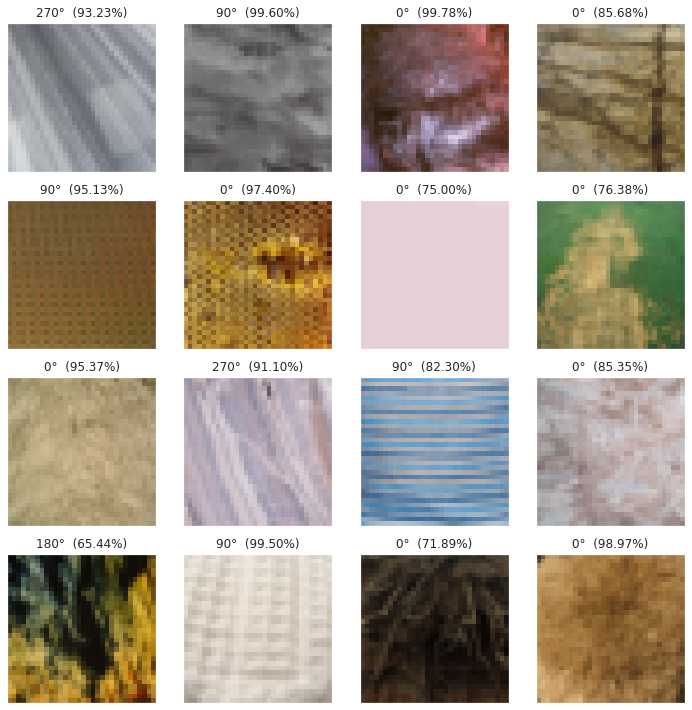

In [73]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
fix, axs = plt.subplots(4,4, figsize=(10, 10))

y_hat, conf = output.softmax(dim=1).max(dim=1)

for ax, img, c, y in zip(axs.flatten(), batch, y_hat, conf):

    ax.imshow(to_pil_image(img))
    ax.set_title(f"{[0, 90, 180, 270][y.item()]}°  ({c:.2%})")
    ax.grid(False)
    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(pad=1)
plt.savefig("/home/ki/image.pdf", transparent=True)
